# Posterior Estimation for SIR-like Models

_Author: Stefan T. Radev_

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

In [2]:
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras

import bayesflow as bf

INFO:bayesflow:Using backend 'jax'


## Introduction

In this tutorial, we will illustrate how to perform posterior inference on simple, stationary SIR-like models (complex models will be tackled in a further notebook). SIR-like models comprise suitable illustrative examples, since they generate time-series and their outputs represent the results of solving a system of ordinary differential equations (ODEs).

The details for tackling stochastic epidemiological models with neural networks are described in our corresponding paper, which you can consult for a more formal exposition and a more comprehensive treatment of neural architectures:

OutbreakFlow: Model-based Bayesian inference of disease outbreak dynamics with invertible neural networks and its application to the COVID-19 pandemics in Germany. https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009472

## Defining the Simulator <a class="anchor" id="defining_the_generative"></a>

In [3]:
RNG = np.random.default_rng(2025)

As described in our [very first notebook](Linear_Regression_Starter.ipynb), a generative model consists of a prior (encoding suitable parameter ranges) and a simulator (generating data given simulations). Our underlying model distinguishes between susceptible, $S$, infected, $I$, and recovered, $R$, individuals with infection and recovery occurring at a constant transmission rate $\lambda$ and constant recovery rate $\mu$, respectively. The model dynamics are governed by the following system of ODEs:

$$
\begin{align}
    \frac{dS}{dt} &= -\lambda\,\left(\frac{S\,I}{N}\right) \\
    \frac{dI}{dt} &= \lambda\,\left(\frac{S\,I}{N}\right) - \mu\,I \\
    \frac{dR}{dt} &= \mu\,I,
\end{align}
$$

with $N = S + I + R$ denoting the total population size. For the purpose of forward inference (simulation), we will use a time step of $dt = 1$, corresponding to daily case reports. In addition to the ODE parameters $\lambda$ and $\mu$, we consider a reporting delay parameter $L$ and a dispersion parameter $\psi$, which affect the number of reported infected individuals via a negative binomial disttribution (https://en.wikipedia.org/wiki/Negative_binomial_distribution):

$$
\begin{equation}
    I_t^{(obs)} \sim \textrm{NegBinomial}(I^{(new)}_{t-L}, \psi),
\end{equation}
$$

In this way, we connect the latent disease model to an observation model, which renders the relationship between parameters and data a stochastic one. Note, that the observation model induces a further parameter $\psi$, responsible for the dispersion of the noise.
Finally, we will also treat the number of initially infected individuals, $I_0$ as an unknown parameter (having its own prior distribution).

### Prior <a class="anchor" id="prior"></a>

We will place the following prior distributions over the five model parameters, summarized in the table below:

$$
\begin{aligned}
& \text {Table 1. Description of model parameters and corresponding prior distributions}\\
&\begin{array}{lcl}
\hline \hline \text { Description} & \text { Symbol } & \text { Prior Distribution } \\
\hline \hline \text{Initial transmission rate} & \text{$\lambda$} & \text{$\textrm{LogNormal}(\log(0.4), 0.5)$} \\
\text{Recovery rate of infected individuals} & \text{$\mu$} & \text{$\textrm{LogNormal}(\log(1/8), 0.2)$} \\
\text{Reporting delay (lag)} & \text{$L$} & \text{$\textrm{LogNormal}(\log(8), 0.2)$} \\
\text{Number of initially infected individuals} & \text{$I_0$} & \text{$\textrm{Gamma}(2, 20)$} \\
\text{Dispersion of the negative binomial distribution} & \text{$\psi$} & \text{$\textrm{Exponential}(5)$} \\
\hline
\end{array}
\end{aligned}
$$

How did we come up with these priors? In this case, we rely on the domain expertise and previous research  (https://www.science.org/doi/10.1126/science.abb9789). In addition, the new parameter $\psi$ follows an exponential distribution, which restricts it to positive numbers. Below is the implementation of these priors:

In [4]:
def prior():
    """Generates a random draw from the joint prior."""

    lambd = RNG.lognormal(mean=np.log(0.4), sigma=0.5)
    mu = RNG.lognormal(mean=np.log(1 / 8), sigma=0.2)
    D = RNG.lognormal(mean=np.log(8), sigma=0.2)
    I0 = RNG.gamma(shape=2, scale=20)
    psi = RNG.exponential(5)
    return {"lambd": lambd, "mu": mu, "D": D, "I0": I0, "psi": psi}

### Observation Model (Implicit Likelihood Function) <a class="anchor" id="simulator__implicit_likelihood"></a>

In [5]:
def convert_params(mu, phi):
    """Helper function to convert mean/dispersion parameterization of a negative binomial to N and p,
    as expected by numpy's negative_binomial.

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """

    r = phi
    var = mu + 1 / r * mu**2
    p = (var - mu) / var
    return r, 1 - p


def stationary_SIR(lambd, mu, D, I0, psi, N=83e6, T=14, eps=1e-5):
    """Performs a forward simulation from the stationary SIR model given a random draw from the prior."""

    # Extract parameters and round I0 and D
    I0 = np.ceil(I0)
    D = int(round(D))

    # Initial conditions
    S, I, R = [N - I0], [I0], [0]

    # Reported new cases
    C = [I0]

    # Simulate T-1 timesteps
    for t in range(1, T + D):
        # Calculate new cases
        I_new = lambd * (I[-1] * S[-1] / N)

        # SIR equations
        S_t = S[-1] - I_new
        I_t = np.clip(I[-1] + I_new - mu * I[-1], 0.0, N)
        R_t = np.clip(R[-1] + mu * I[-1], 0.0, N)

        # Track
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
        C.append(I_new)

    reparam = convert_params(np.clip(np.array(C[D:]), 0, N) + eps, psi)
    C_obs = RNG.negative_binomial(reparam[0], reparam[1])
    return dict(cases=C_obs)

As you can see, in addition to the parameters, our simulator requires two further arguments: the total population size $N$ and the time horizon $T$. These are quantities over which we can amortize (i.e., context variables), but for this example, we will just use the population of Germany and the first two weeks of the pandemics (i.e., $T=14$), in the same vein as https://www.science.org/doi/10.1126/science.abb9789.

### Loading Real Data <a class="anchor" id="loading_real_data"></a>

We will define a simple helper function to load the actually reported cases in 2020 for the first three weeks of the Covid-19 pandemic in Germany.

In [6]:
def load_data():
    """Helper function to load cumulative cases and transform them to new cases."""

    confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    confirmed_cases = pd.read_csv(confirmed_cases_url, sep=",")

    date_data_begin = datetime.date(2020, 3, 1)
    date_data_end = datetime.date(2020, 3, 15)
    format_date = lambda date_py: f"{date_py.month}/{date_py.day}/{str(date_py.year)[2:4]}"
    date_formatted_begin = format_date(date_data_begin)
    date_formatted_end = format_date(date_data_end)

    cases_obs = np.array(
        confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", date_formatted_begin:date_formatted_end]
    )[0]
    new_cases_obs = np.diff(cases_obs)
    return new_cases_obs

### Stitiching Things Together <a class="anchor" id="generative_model"></a>
We can combine the prior $p(\theta)$ and the observation model $p(x_{1:T}\mid\theta)$ into a joint model $p(\theta, x_{1:T}) = p(\theta) \; p(x_{1:T}\mid\theta)$ using the `make_simulator` builder.
The resulting object can now generate *batches* of simulations.

In [7]:
simulator = bf.make_simulator([prior, stationary_SIR])

In [8]:
test_sims = simulator.sample(batch_size=2)

print(test_sims["lambd"].shape)
print(test_sims["D"].shape)
print(test_sims["cases"].shape)

(2, 1)
(2, 1)
(2, 14)


## Prior Checking <a class="anchor" id="prior_checking"></a>

Any principled Bayesian workflow requires some prior predictive or prior pushforward checks to ensure that the prior specification is consistent with domain expertise (see https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html). The BayesFlow library provides some rudimentary visual tools for performing prior checking. For instance, we can visually inspect the joint prior in the form of bivariate plots. We can focus on particular parameter combinations, such as $\lambda$, $\mu$, and $D$:

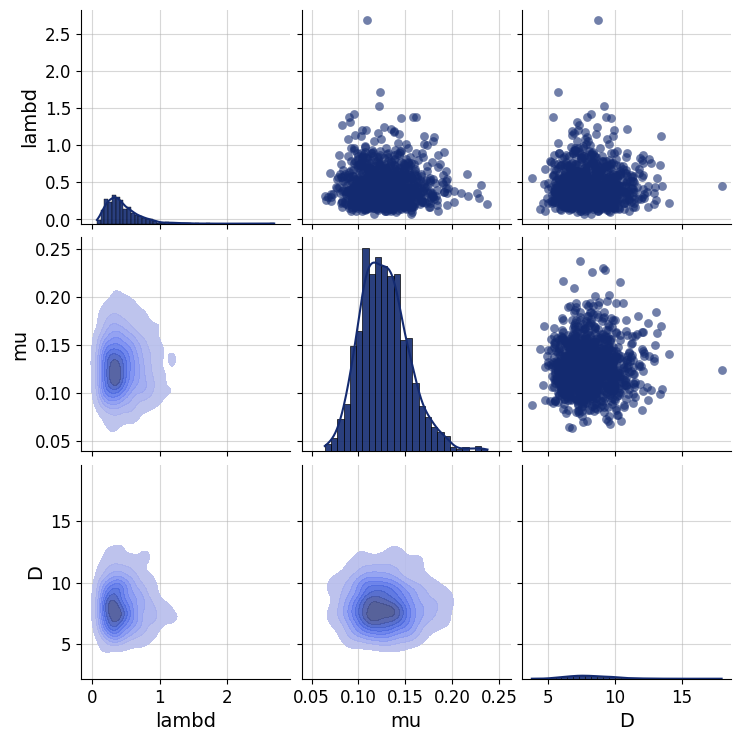

In [9]:
prior_samples = simulator.simulators[0].sample(1000)

grid = bf.diagnostics.plots.pairs_samples(
    prior_samples, variable_keys=["lambd", "mu", "D"]
)

## Defining the Adapter

We need to ensure that the outputs of the forward model are suitable for processing with neural networks. Currently, they are not, since our data $x_{1:T}$ consists of large integer (count) values. However, neural networks like scaled data. Furthermore, our parameters $\theta$ exhibit widely different scales due to their prior specification and role in the simulator. Finally, BayesFlow needs to know which variables are to be inferred and which ones are to be processed by the summary network before being passed to the inference network. We handle all of these steps using an `Adapter`.

Since all of our parameters and observables can only take on positive values, we will apply a log plus one transform to all quantities. Note, that `BayesFlow` expects the following keys to be present in the final outputs of your configured simulations:
- `inference_variables`: These are the variables we are inferring.
- `summary_variables`: These are the variables that are compressed throgh a summary network and used for inferring the inference variables.

Thus, what our approximators are learning is $p(\text{inference variables} \mid t(\text{summary variables}))$, where $t$ is the summary network.

In [10]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("cases")
    .concatenate(["lambd", "mu", "D", "I0", "psi"], into="inference_variables")
    .rename("cases", "summary_variables")
    # since all our variables are non-negative (zero or larger), the next call transforms them
    # to the unconstrained real space and can be back-transformed under the hood
    .log(["inference_variables", "summary_variables"], p1=True)
)

In [11]:
adapter

Adapter([0: ConvertDType -> 1: AsTimeSeries -> 2: Concatenate(['lambd', 'mu', 'D', 'I0', 'psi'] -> 'inference_variables') -> 3: Rename('cases' -> 'summary_variables') -> 4: Log])

In [12]:
# Let's check out the new shapes
adapted_sims = adapter(simulator.sample(2))
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(2, 14, 1)
(2, 5)


## Defining the Neural Approximator <a class="anchor" id="defining_the_neural"></a>

We can now proceed to define our `BayesFlow` neural architecture, that is, combine a summary network with an inference network.

### Summary Network <a class="anchor" id="summary_network"></a>

Since our simulator outputs 3D tensors of shape ``(batch_size, T = 14, 1)``, we need to reduce this three-dimensional tensor into a two-dimensional tensor of shape ``(batch_size, summary_dim)``. Our model outputs are actually so simple that we could have just removed the trailing dimension of the raw outputs and simply fed the data directly to the inference network.

However, we demonstrate the use of a simple Gated Recurrent Unit (GRU) summary network. Any `keras` model can interact with `BayesFlow` by inherting from `SummaryNetwork` which accepts an addition `stage` argument indicating the mode the network is currently operating in (i.e., `training` vs. `inference`).

In [13]:
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(8)
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary

In [14]:
summary_net = GRU()

### Inference Network

As a backbone inference network, we choose the all-time classic coupling flow (i.e., a type of normalizing flow).

In [15]:
inference_net = bf.networks.CouplingFlow()

### Workflow
Inference with workflows is easy. Simply provide the simulator, adapter, and network objects, and have fun! If you want to save the networks automatically after training, provide a `checkpoint_filepath` and an optional `checkpoint_name`.

In [16]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=inference_net,
    summary_network=summary_net,
    standardize=None # no need to standardize due to log-transform
)

## Training <a class="anchor" id="training"></a>

Ready to train! Since our simulator is pretty fast, we can safely go with online training. Let's glean the time taken for a batch of $32$ simulations.

In [17]:
%%time
_ = workflow.simulate(32)

CPU times: total: 0 ns
Wall time: 8.68 ms


Not too bad! However, for the purpose of illustration, we will go with offline training using a fixed data set of 6000 simulations. This may be considered a "low simulation budget" in many settings.

### Generating Offline Data <a class="anchor" id="generating_offline_data"></a>

In [18]:
training_data = workflow.simulate(6000)
validation_data = workflow.simulate(300)

We are now ready to train. If not provided, the default settings use $100$ epochs with a batch size of $64$. The training time for this network is below 1 minute.

In [ ]:
history = workflow.fit_offline(
    data=training_data, 
    epochs=100, 
    batch_size=64, 
    validation_data=validation_data
)

### Inspecting the Loss <a class="anchor" id="inspecting_the_loss"></a>

Following our online simulation-based training, we can quickly visualize the loss trajectory using the `plots.loss` function from the `diagnostics` module.

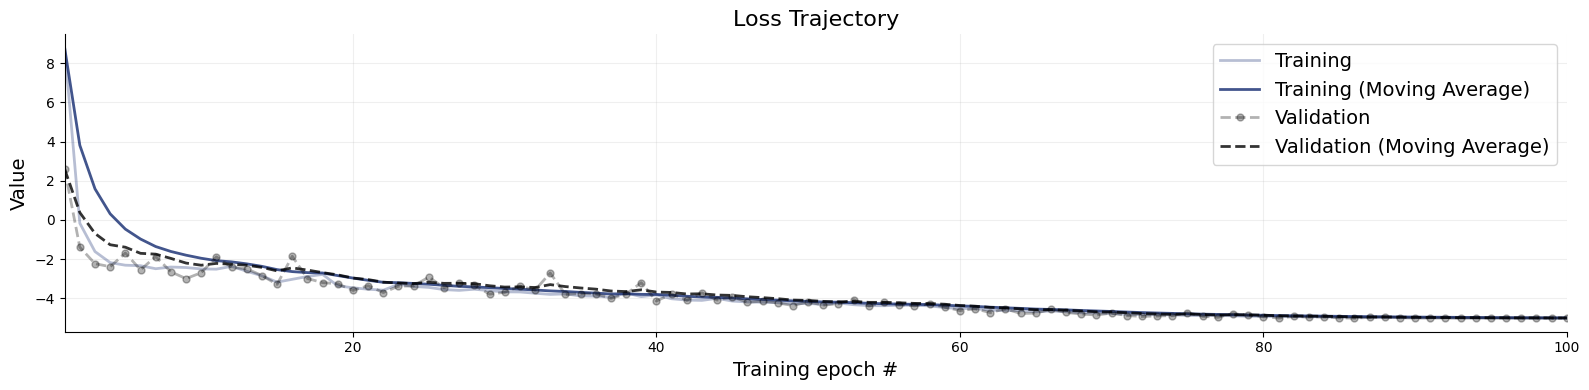

In [21]:
f = bf.diagnostics.plots.loss(history)

Great, it seems that our approximator has converged! Before we get too excited and throw our networks at real data, we need to make sure that they meet our expectations <em>in silico</em>, that is, given the small world of simulations the networks have seen during training.

## Validation Phase

When it comes to validating posterior inference, we can either deploy manual diagnostics from the `diagnostics` module, or use the automated functions from the `BasicWorkflow` object. First, we demonstrate manual validation. 

In [22]:
# Set the number of posterior draws you want to get
num_datasets = 300
num_samples = 1000

# Simulate 300 scenarios
test_sims = workflow.simulate(num_datasets)

# Obtain num_samples posterior samples per scenario
samples = workflow.sample(conditions=test_sims, num_samples=num_samples)

### Simulation-Based Calibration - Rank Histograms

As a further <strong>small world</strong> (i.e., before real data) sanity check, we can also test the calibration of the amortizer through simulation-based calibration (SBC). See the corresponding paper for more details (https://arxiv.org/pdf/1804.06788.pdf). Accordingly, we expect to observe approximately uniform rank statistic histograms. In the present case, this is indeed what we get:

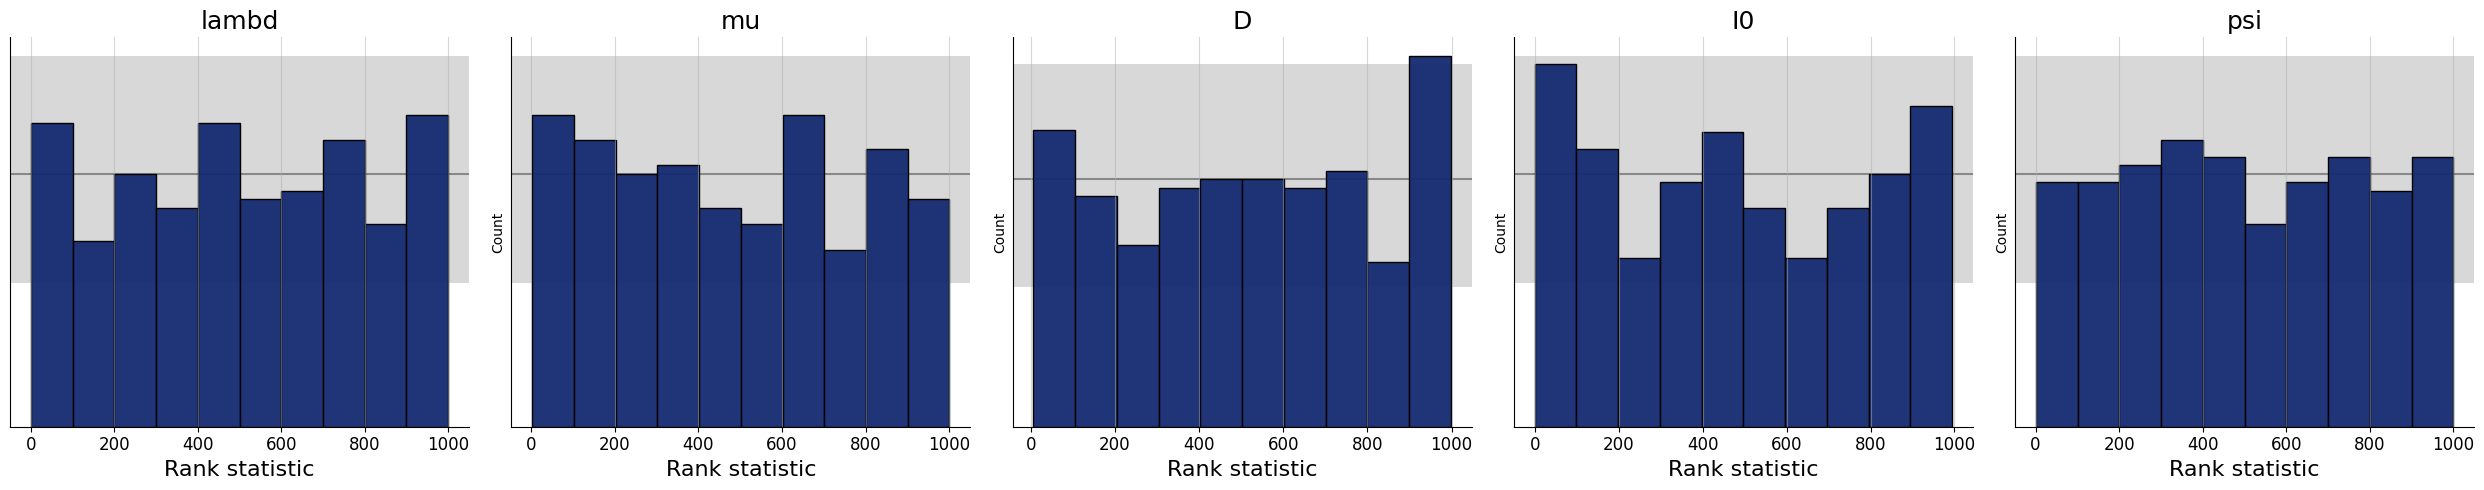

In [23]:
f = bf.diagnostics.plots.calibration_histogram(samples, test_sims)

### Simulation-Based Calibration - Rank ECDF

For models with many parameters, inspecting many histograms can become unwieldly. Moreover, the `num_bins` hyperparameter for the construction of SBC rank histograms can be hard to choose. An alternative diagnostic approach for calibration is through empirical cumulative distribution functions (ECDF) of rank statistics. You can read more about this approach in the corresponding paper (https://arxiv.org/abs/2103.10522).

In order to inspect the ECDFs of marginal distributions, we will simulate $300$ new pairs of simulated data and generating parameters $(\boldsymbol{x}, \boldsymbol{\theta})$ and use the function `plots.calibration_ecdf` from the `diagnostics` module: 

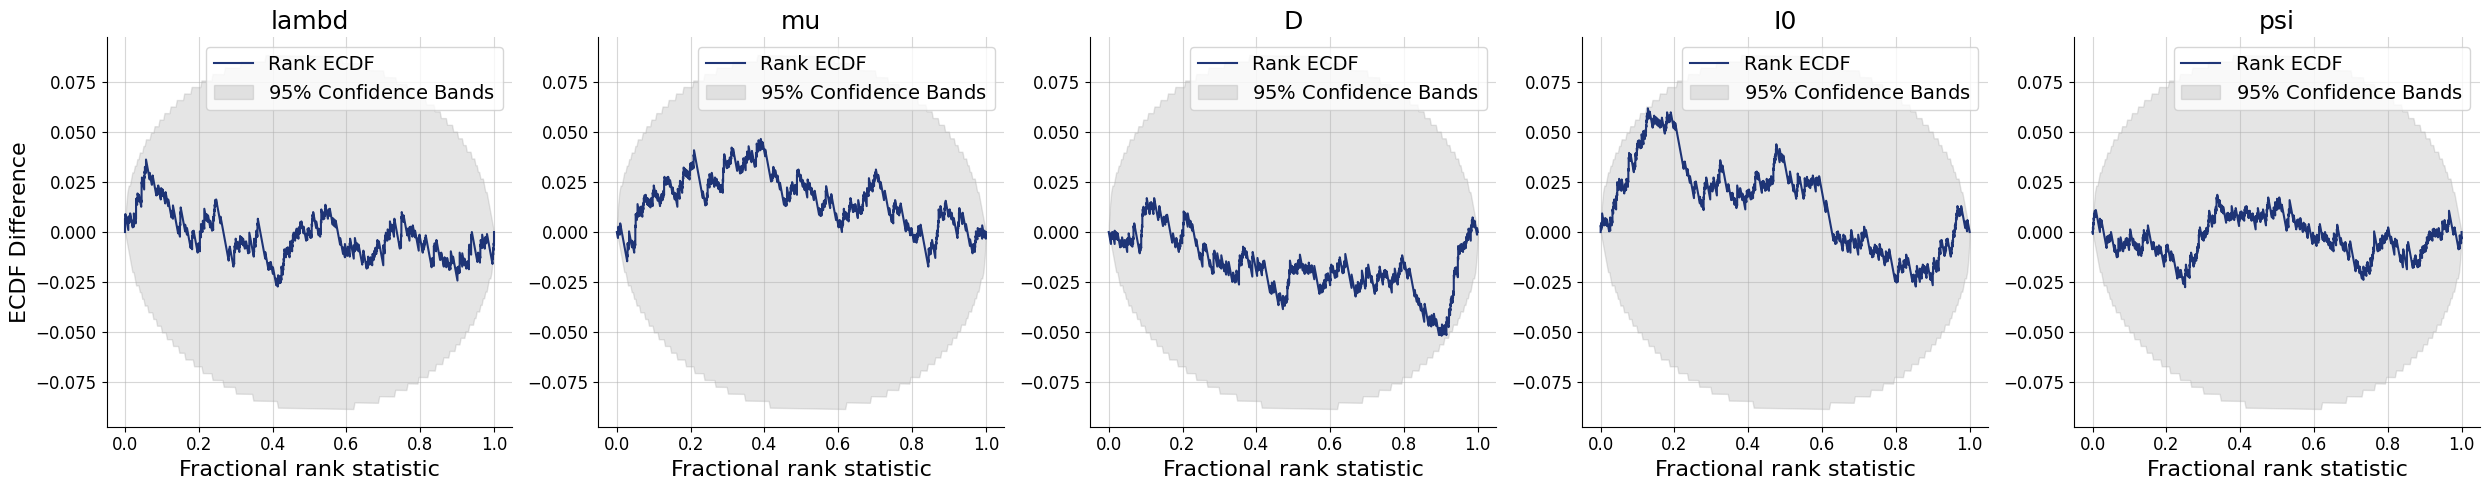

In [24]:
f = bf.diagnostics.plots.calibration_ecdf(samples, test_sims, difference=True)

### Inferential Adequacy (Global)

Depending on the application, it might be interesting to see how well summaries of the full posterior (e.g., means, medians) recover the assumed true parameter values. We can test this <em>in silico</em> via the `plots.recovery` function in the `diagnostics` module. For instance, we can compare how well posterior means recover the true parameter (i.e., posterior z-score, https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html):

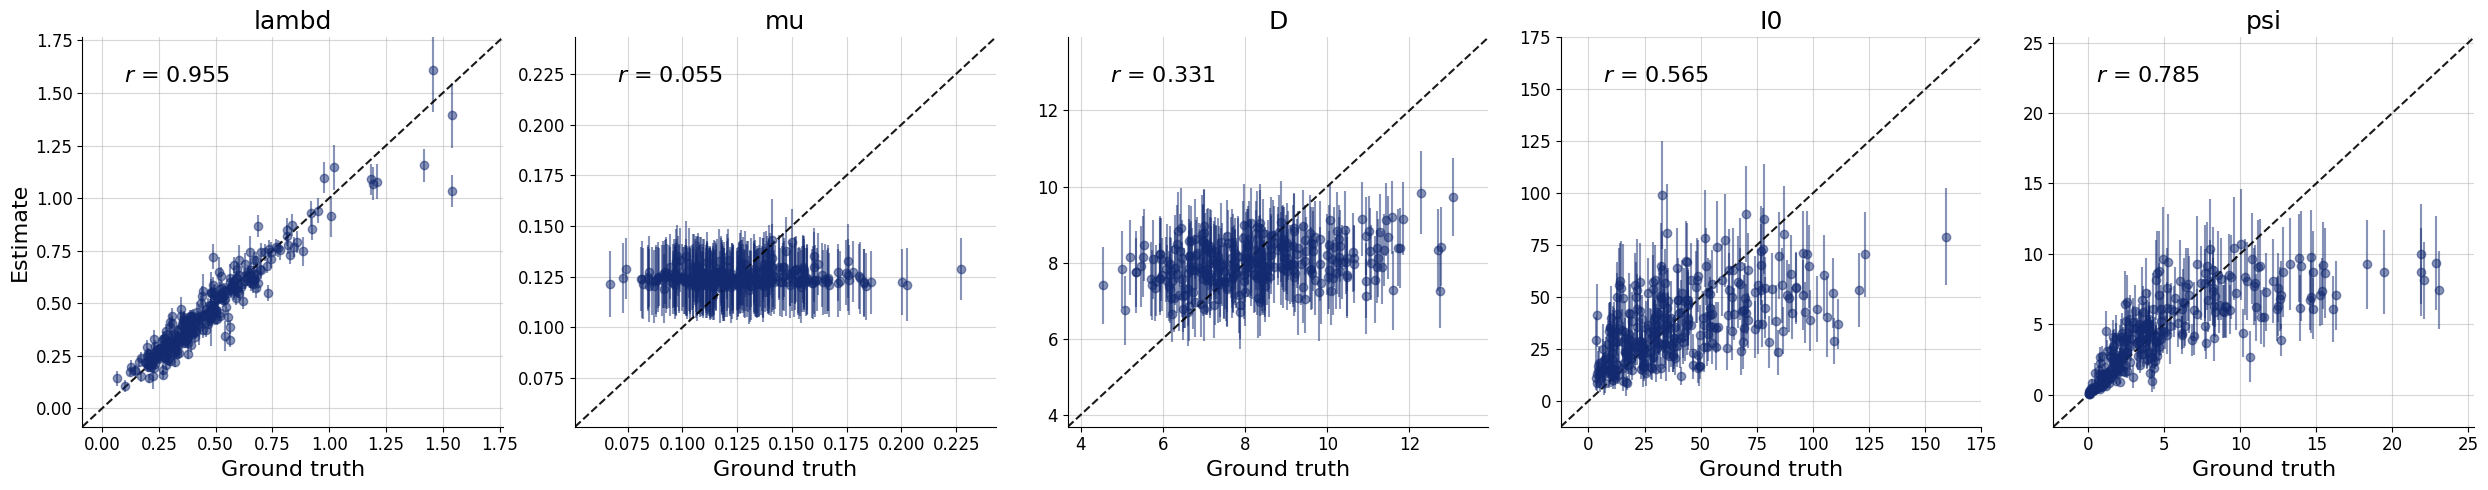

In [25]:
f = bf.diagnostics.plots.recovery(samples, test_sims)

Interestingly, it seems that the parameters $\theta_1 = \mu$ and $\theta_2 = D$ have not been learned properly as they are estimated roughly the same for every simulated datset used during testing. For some models, this might indicate that the the network training had partially failed; and we would have to train longer or adjust the network architecture. For this specific model, however, the reason is different: From the provided observables, these parameters are actually not identified so cannot be learned consistently, no matter the kind of approximator we would use. 

### Automatic Diagnostics

The basic workflow object wraps together a bunch of useful functions that can be called automatically. For instance, we can easily obtain numerical error estimates for the big three: normalized roor mean square error (NRMSE), posterior contraction, and calibration, for $300$ new data sets:

In [26]:
metrics = workflow.compute_default_diagnostics(test_data=300)
metrics

,lambd,mu,D,I0,psi
NRMSE,0.079257,0.246147,0.231538,0.199334,0.173794
Posterior Contraction,0.945971,0.078332,0.070332,0.546068,0.718773
Calibration Error,0.011930,0.025263,0.013246,0.040614,0.004737


We can also obtain the full set of graphical diagnostics:

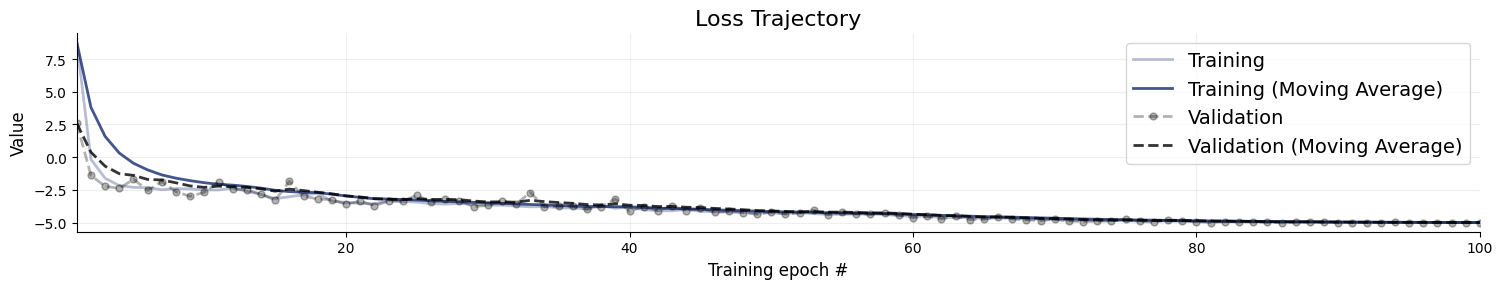

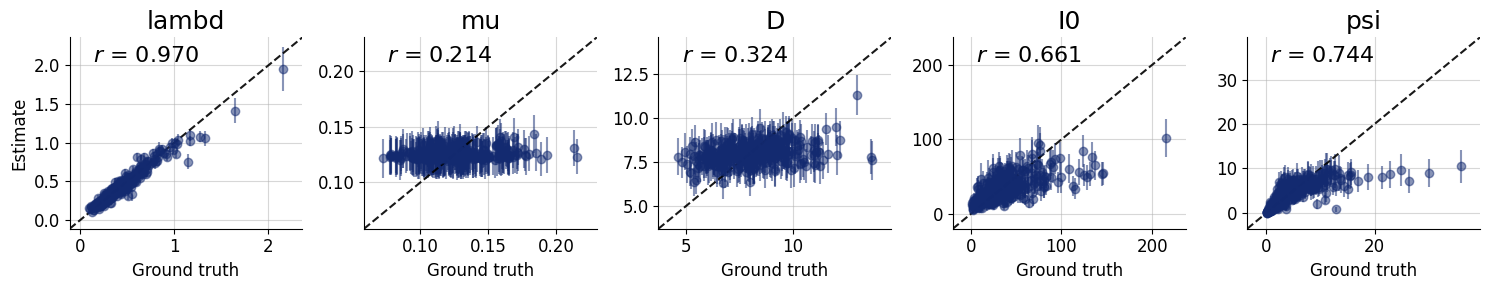

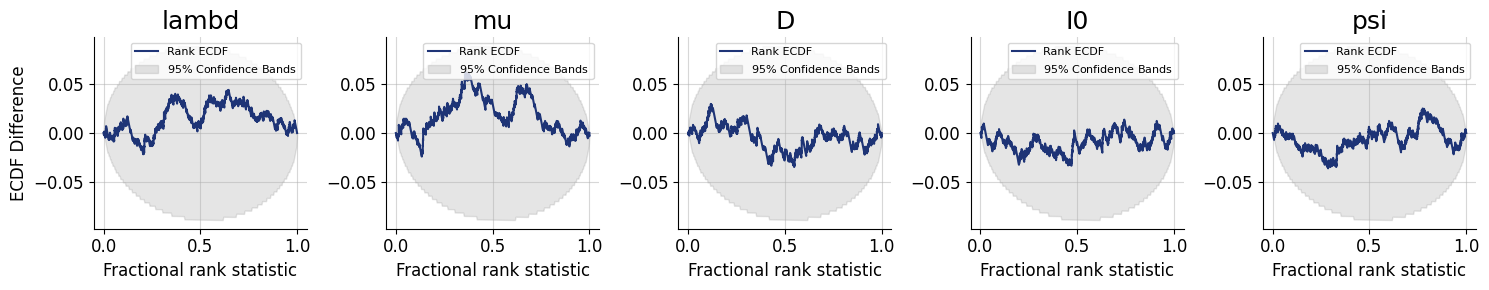

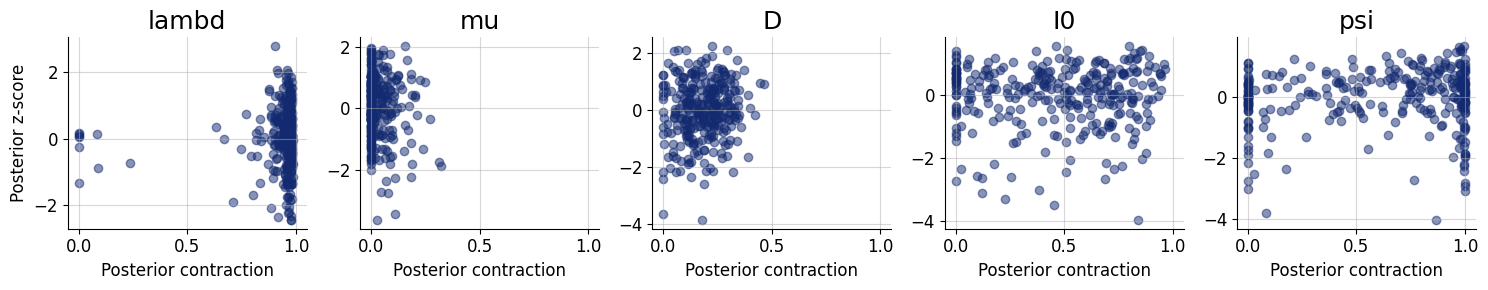

In [27]:
figures = workflow.plot_default_diagnostics(
    test_data=300,
    loss_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    recovery_kwargs={"figsize": (15, 3), "label_fontsize": 12},
    calibration_ecdf_kwargs={"figsize": (15, 3), "legend_fontsize": 8, "difference": True, "label_fontsize": 12},
    z_score_contraction_kwargs={"figsize": (15, 3), "label_fontsize": 12}    
)

## Inference Phase <a class="anchor" id="inference_phase"></a>

We can now move on to using real data. This is easy, and since we are using an adapter, the same transformations applied during training will be applied during the inference phase.

In [29]:
# Our real-data loader returns the time series as a 1D array
obs_cases = load_data()

# Note that we transform the 1D array into shape (1, T), indicating one time series
samples = workflow.sample(conditions={"cases": obs_cases[None, :]}, num_samples=num_samples)

# Convert into a nice format 2D data frame
samples = workflow.samples_to_data_frame(samples)

samples.head()

,lambd,mu,D,I0,psi
0,0.403132,0.132537,8.742765,18.748758,8.087518
1,0.386655,0.125630,7.554114,27.330902,17.882437
2,0.390225,0.117071,14.507048,5.123773,8.285616
3,0.394396,0.114620,9.687984,14.718996,5.073137
4,0.373933,0.119038,6.440099,33.536617,9.953448


### Posterior Retrodictive Checks <a class="anchor" id="posterior_retrodictive_checks"></a>

These are also called <em>posterior predictive checks</em>, but here we want to explicitly highlight the fact that we are not predicting future data but testing the <strong>generative performance</strong> or <strong>re-simulation performance</strong> of the model. In other words, we want to test how well the simulator can reproduce the actually observed data given the parameter posterior $p(\theta \mid h(x_{1:T}))$. 

Here, we will create a custom function which plots the observed data and then overlays draws from the posterior predictive.

In [30]:
def plot_ppc(samples, obs_cases, logscale=True, color="#132a70", figsize=(12, 6), font_size=18):
    """
    Helper function to perform some plotting of the posterior predictive.
    """
    # Plot settings
    plt.rcParams["font.size"] = font_size
    f, ax = plt.subplots(1, 1, figsize=figsize)
    T = len(obs_cases)

    # Re-simulations
    sims = []
    for i in range(samples.shape[0]):
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim
        sim_cases = stationary_SIR(*samples.values[i])
        sims.append(sim_cases["cases"])
    sims = np.array(sims)

    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)

    # Plot median predictions and observed data
    ax.plot(np.median(sims, axis=0), label="Median predicted cases", color=color)
    ax.plot(obs_cases, marker="o", label="Reported cases", color="black", linestyle="dashed", alpha=0.8)

    # Add compatibility intervals (also called credible intervals)
    ax.fill_between(range(T), qs_50[0], qs_50[1], color=color, alpha=0.5, label="50% CI")
    ax.fill_between(range(T), qs_90[0], qs_90[1], color=color, alpha=0.3, label="90% CI")
    ax.fill_between(range(T), qs_95[0], qs_95[1], color=color, alpha=0.1, label="95% CI")

    # Grid and schmuck
    ax.grid(color="grey", linestyle="-", linewidth=0.25, alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("Days since pandemic onset")
    ax.set_ylabel("Number of cases")
    ax.minorticks_off()
    if logscale:
        ax.set_yscale("log")
    ax.legend(fontsize=font_size)
    return f

We can now go on and plot the re-simulations (i.e., perform a posterior "predictive" check on the fitted data):

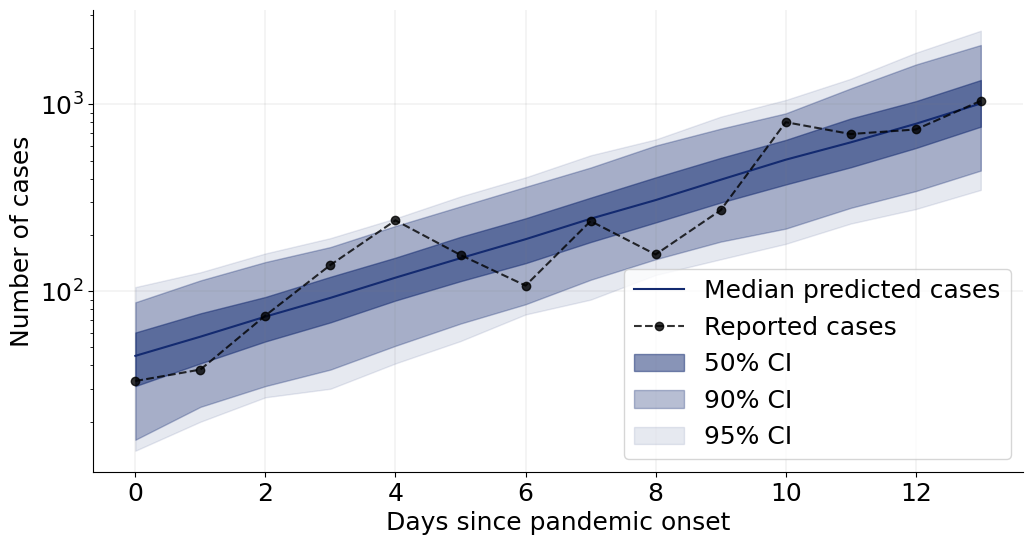

In [31]:
f = plot_ppc(samples, obs_cases)

That's it for this tutorial! You now know how to use the basic building blocks of `BayesFlow` to create amortized neural approximators. :)

<!-- In the [next tutorial](./PriorSensitivity_Covid19_Initial.ipynb), we will go through a <strong>prior sensitivity analysis</strong> with `BayesFlow`, which is as easy to perform as it is important for ascertaining the robustness of our inferences. -->